In [52]:
import aomip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from tifffile import imsave, imread
import json
from os.path import join
from skimage.io import imread, imsave
import tifffile

### Homework 1&2: More Proximal Operators + ADMM

In [53]:
C = np.array([[2, 1], [1, 1]])
d = np.array([1, 1])
xstart=np.array([3, 1])
taus = np.logspace(-5, 4, 10)


Below experimental results illustrate the least square problem with lasso formulation which is solved using the linearized ADMM method implemented this week. The target solution is [0,1] for this problem. As can be seen from the result, lower value of regularization paramter tau around the range of [1e-4,1e-2] produces better results than regularization parameter that are much higher or lower. This is just a simple case study to show that the algorithm is working.

In [54]:
fs = []
fy = []
proxParams = {'v':d, 'x':xstart, 'tau':0.01}

dF = lambda x : (C.T).dot(C.dot(x)-d)
xmin, stopIdx = aomip.pogm(C,d,xstart,aomip.proximalL1,proxParams,iteration=1000)
print("target: ",xmin)
print(stopIdx)

for i,tau in enumerate(taus):
    proxParamsf = {'v':xstart, 'x':xstart, 'tau':tau}
    proxParamsg = {'v':xstart, 'x':xstart, 'y':d, 'tau':tau,'g':aomip.proximalL2Squared}
    xmin, stopIdx = aomip.admm_lasso(C,d,xstart,aomip.proximalL1,aomip.proximalTranslation,proxParamsf,proxParamsg,tau,iteration=5000)
    print('xmin: ',xmin)
    print("iteration: ",stopIdx)


final x:  [0.00988597 0.9801845 ]
target:  [0.00988597 0.9801845 ]
347
tau:  1e-05
xmin:  [2.99999986 0.99999986]
iteration:  1
tau:  0.0001
xmin:  [3.59812231e-04 9.99379615e-01]
iteration:  3992
tau:  0.001
xmin:  [0.00125948 0.99758015]
iteration:  3991
tau:  0.01
xmin:  [0.01025951 0.97958011]
iteration:  3975
tau:  0.1
xmin:  [0.10025987 0.79957952]
iteration:  3835
tau:  1.0
xmin:  [0.40001357 0.        ]
iteration:  179
tau:  10.0
xmin:  [0. 0.]
iteration:  17
tau:  100.0
xmin:  [0. 0.]
iteration:  3
tau:  1000.0
xmin:  [0. 0.]
iteration:  1
tau:  10000.0
xmin:  [0. 0.]
iteration:  1


### (ii) TV regularization

[2023-07-05 20:09:12.935] [CircleTrajectoryGenerator] [info] creating 2D trajectory with 512 poses in an 360 degree arc


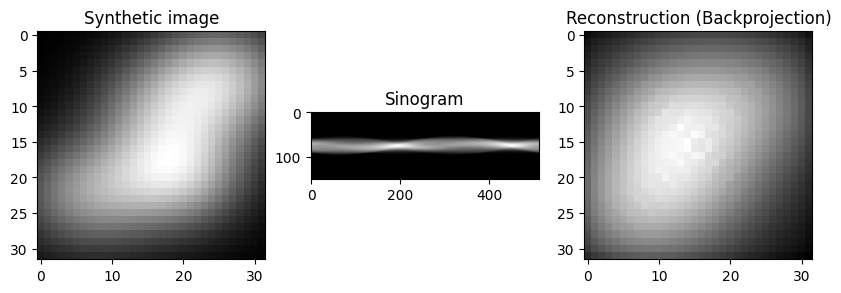

In [59]:
def smooth(N):
    I, J = np.meshgrid(np.arange(N), np.arange(N))
    sigma = 0.25 * N
    c = np.array([[0.6*N, 0.6*N], [0.5*N, 0.3*N], [0.2*N, 0.7*N], [0.8*N, 0.2*N]])
    a = np.array([1, 0.5, 0.7, 0.9])
    img = np.zeros((N, N))
    for i in range(4):
        term1 = (I - c[i, 0])**2 / (1.2 * sigma )**2
        term2 = (J - c[i, 1])**2 / sigma**2
        img += a[i] * np.exp(-term1 - term2)
    return img

syntheticImg = smooth(32)
size = np.array([32, 32])
num_angles = 512
arc = 360
A = aomip.XrayOperator(size, [150], np.linspace(0, arc, num_angles), size[0]*100, size[0]*2)
sinogram = A.apply(syntheticImg)
sinogram = np.flip(sinogram,axis=0)
reconstruct = A.applyAdjoint(sinogram)

plt.figure(figsize=(10,10))
plt.subplot(1,3,1, title="Synthetic image");plt.imshow(syntheticImg, cmap='gray')
plt.subplot(1,3,2, title="Sinogram");plt.imshow(sinogram, cmap='gray')
plt.subplot(1,3,3, title="Reconstruction (Backprojection)");plt.imshow(reconstruct, cmap='gray')
plt.show()


In [60]:
x0 = np.zeros_like(syntheticImg)
grad = aomip.FirstDerivative()
rawGrad = grad.apply(syntheticImg)
gradBlock = aomip.resize_image_grad(np.zeros_like(rawGrad))


iteration:  20


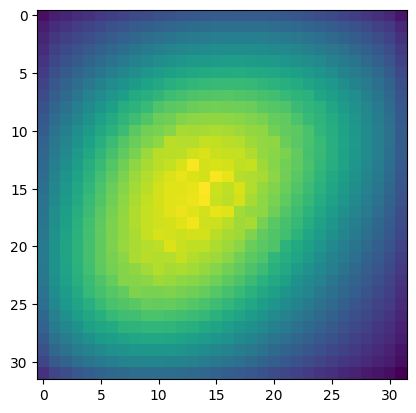

In [61]:
stackedOpt = aomip.StackedOperator()
grad = aomip.FirstDerivative()
gradShape = grad.apply(x0)
gradBlock = np.zeros_like(gradShape)   #(2,32,32)

opts = [A,grad]
xstacked = [x0,x0]
bstacked = [sinogram, gradBlock]


leftBlock = stackedOpt.apply(opts,xstacked)
adjBlock = stackedOpt.applyAdjoint(opts,bstacked)
rightBlock = [sinogram,gradBlock]

L = 7.931346 ## aomip.get_largest_sigma(A,100)
alpha = 1/L
alpha = float(format(1/L, '.0e'))
tau = 100
lambd = (0.95*tau)/ (L**2)
proxParamsf = {'v':x0, 'x':x0, 'y':sinogram, 'g':aomip.proximalIdentity}

step = 1
def callback1(x,i):
    if i % step == 0:
        fs.append(x)
        
# anisotropic
fs = []
blockProxG = [aomip.proximalTranslation, aomip.proximalL21]
proxParamg1 = {'v':x0,'y':-sinogram, 'sigma':alpha, 'beta':1, 'g':aomip.proximalL2Squared}
proxParamg2 = {'v':x0, 'sigma':alpha, 'tau':lambd}
blockProxpramsG = [proxParamg1,proxParamg2]
reconImg, stopIdx = aomip.admm_tv(bstacked,xstacked,stackedOpt,opts,blockProxG,blockProxpramsG,lambd,tau,iteration=20,callback=callback1)
print("iteration: ",stopIdx)
plt.imshow(reconImg)


In [ ]:
plt.imsave()